# Rossmann Store Sales
### Forecast sales using store, promotion, and competitor data


Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column.

Data fields
* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Importing Necessary Libraries

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.__version__

'0.11.2'

## Let's explore what our data looks like

### Store Details Lookup

In [3]:
store_details = pd.read_csv('data/store.csv')
store_details.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Train Data

In [4]:
#Our Train Data
train_data = pd.read_csv("data/train.csv")
train_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


### Merging Store Details Lookup Table with Train Data

In [5]:
#merged our train data and store details data based on store number to get complete information for each store
combined_data = pd.merge(train_data, store_details, on = "Store")
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [6]:
combined_data.shape

(1017209, 18)

# Exploratory Data Analysis

## Check for the Missing Data

In [7]:
print("Total size of a dataset:", len(combined_data))

Total size of a dataset: 1017209


In [8]:
print(combined_data.isnull().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


## Finding Unique Values in a Dataset

In [9]:
#Get the Columns
columns = list(combined_data.columns)
#remove the date column
columns.remove('Date')
#Remove Competition Distance
columns.remove('CompetitionDistance')

#check unique values per column
for col in columns:
    print(col, "---------->", combined_data[col].unique())

Store ----------> [   1    2    3 ... 1113 1114 1115]
DayOfWeek ----------> [5 4 3 2 1 7 6]
Sales ----------> [ 5263  5020  4782 ... 20362 18841 21237]
Customers ----------> [ 555  546  523 ... 3727 4022 4106]
Open ----------> [1 0]
Promo ----------> [1 0]
StateHoliday ----------> ['0' 'a' 'b' 'c' 0]
SchoolHoliday ----------> [1 0]
StoreType ----------> ['c' 'a' 'd' 'b']
Assortment ----------> ['a' 'c' 'b']
CompetitionOpenSinceMonth ----------> [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
CompetitionOpenSinceYear ----------> [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Promo2 ----------> [0 1]
Promo2SinceWeek ----------> [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Promo2SinceYear ----------> [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
PromoInterval ----------> [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sep

In [10]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

## Extracting Year and Month from Date

In [11]:
combined_data['Date'].head()

0    2015-07-31
1    2015-07-30
2    2015-07-29
3    2015-07-28
4    2015-07-27
Name: Date, dtype: object

In [12]:
combined_data['Year'] = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))

combined_data['Year'].head()

0    2015
1    2015
2    2015
3    2015
4    2015
Name: Year, dtype: int64

In [13]:
combined_data['Month'].head()

0    7
1    7
2    7
3    7
4    7
Name: Month, dtype: int64

## Sales with Respect to Year

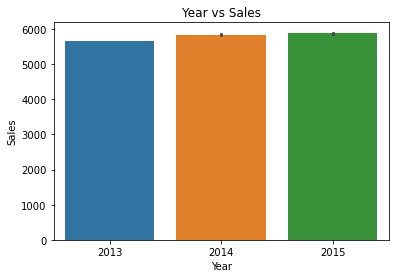

In [14]:
sns.barplot(x = 'Year', y = 'Sales', data = combined_data).set(title = 'Year vs Sales')
plt.show()

Findings: Sales have been increasing per year

## Sales with Respect to the Day of Week

In [15]:
combined_data['Date'] = pd.to_datetime(combined_data['Date'], format='%Y-%m-%d')
combined_data['Date'].head()

0   2015-07-31
1   2015-07-30
2   2015-07-29
3   2015-07-28
4   2015-07-27
Name: Date, dtype: datetime64[ns]

In [16]:
combined_data['DayName'] = combined_data['Date'].dt.day_name()

In [17]:
combined_data[['Date','DayOfWeek','DayName']].head()

,Date,DayOfWeek,DayName
0,2015-07-31,5,Friday
1,2015-07-30,4,Thursday
2,2015-07-29,3,Wednesday
3,2015-07-28,2,Tuesday
4,2015-07-27,1,Monday


<function matplotlib.pyplot.show(close=None, block=None)>

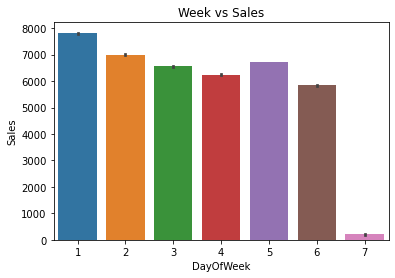

In [18]:
sns.barplot(x = 'DayOfWeek', y = 'Sales', data = combined_data).set(title = 'Week vs Sales')
plt.show

Findings: Sales on 1 (Monday), on 2 (Tuesday), and 5 (Friday)

In [19]:
data_week = combined_data.groupby(['DayOfWeek','DayName']).mean()['Sales']
data_week

DayOfWeek  DayName  
1          Monday       7809.044510
2          Tuesday      7005.244467
3          Wednesday    6555.884138
4          Thursday     6247.575913
5          Friday       6723.274305
6          Saturday     5847.562599
7          Sunday        204.183189
Name: Sales, dtype: float64

## Sales with respect to Promotions

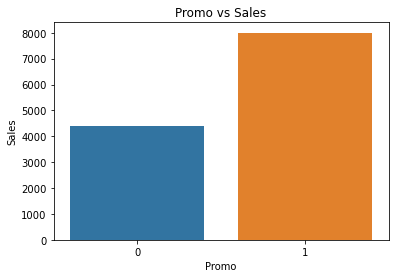

In [20]:
sns.barplot(x = 'Promo', y = 'Sales', data = combined_data).set(title = 'Promo vs Sales')
plt.show()

Findings: Customers are attracted to Promo Codes thus sales are higher when there is a Promo Code in a Store

## Sales with Respect to State Holiday

In [21]:
combined_data['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [22]:
#StateHoliday Column has values 0 & "0". So, we need to change values with 0 to "0"
combined_data.loc[combined_data['StateHoliday'] == 0, 'StateHoliday'] = "0"

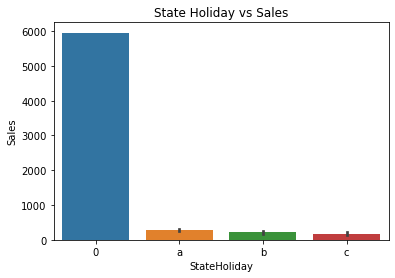

In [23]:
sns.barplot(x = "StateHoliday", y = "Sales", data = combined_data).set(title = "State Holiday vs Sales")
plt.show()

### Mapping the State Holiday
Findings: Most Stores are closed on State Holiday. Fewer Sales are observed in a,b,c where:
- a = Public Holiday
- b = Easter Holiday
- c = Christmas
- 0 = No Holiday, Working Day

In [24]:
state_holiday_dict = {"a": "Public Holiday", "b": "Easter Holiday", "c":"Christmas", "0" : "No Holiday, Working Day"}
combined_data['StateHolidayName'] = combined_data['StateHoliday'].map(state_holiday_dict)

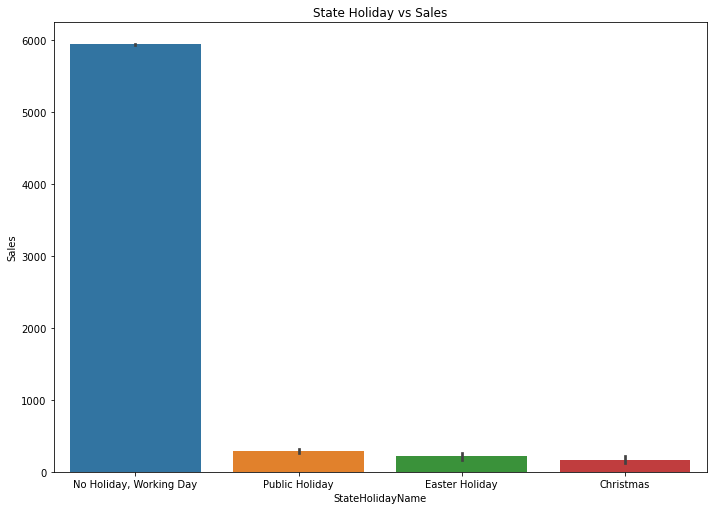

In [25]:
fig, ax = plt.subplots()
sns.barplot(x = "StateHolidayName", y = "Sales", data = combined_data,  ax=ax).set(title = "State Holiday vs Sales")
fig.set_size_inches(11.7, 8.27)
plt.show()

In [26]:
data_holiday = combined_data.groupby(['StateHolidayName']).sum()['Sales']
data_holiday

StateHolidayName
Christmas                      691806
Easter Holiday                1433744
No Holiday, Working Day    5865164768
Public Holiday                5890305
Name: Sales, dtype: int64

## Sales with Respect to School Holiday

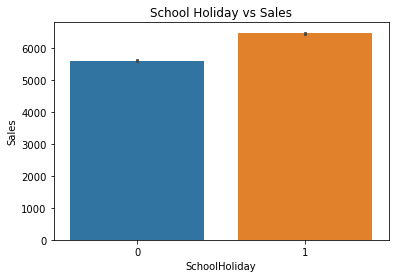

In [27]:
sns.barplot(x = "SchoolHoliday", y = "Sales", data = combined_data).set(title = "School Holiday vs Sales")
plt.show()

#### Findings: More Sales occur in School Holidays compared to Non-School Holidays

In [28]:
data_holiday_school = combined_data.groupby(["SchoolHoliday"]).mean()['Sales']
data_holiday_school

SchoolHoliday
0    5620.979034
1    6476.522207
Name: Sales, dtype: float64

## Sales with Respect to Store Type

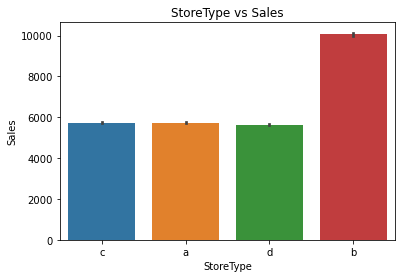

In [29]:
sns.barplot(x = "StoreType", y = "Sales", data = combined_data).set(title = "StoreType vs Sales")
plt.show()

#### Findings: Store Type B have the highest Sales

In [30]:
data_store_type = combined_data.groupby(["StoreType"]).mean()['Sales']
data_store_type

StoreType
a     5738.179710
b    10058.837334
c     5723.629246
d     5641.819243
Name: Sales, dtype: float64

## Sales with Respect to Assortment

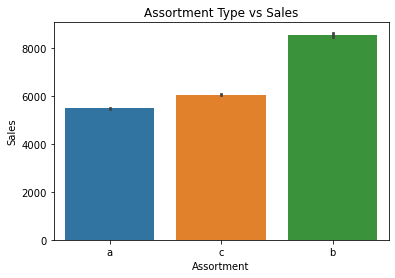

In [31]:
sns.barplot(x = "Assortment", y = "Sales", data = combined_data).set(title = "Assortment Type vs Sales")
plt.show()

#### Mapping the Assortment Level
Assortment Levels where:
- a = basic
- b = extra
- c = extended

In [32]:
assortment_type_dict = {"a": "Basic", "b": "Extra", "c":"Extended"}
combined_data['Assortment Type Name'] = combined_data['Assortment'].map(assortment_type_dict)

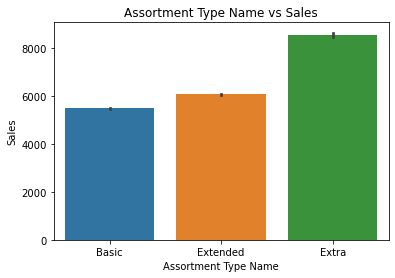

In [33]:
sns.barplot(x = "Assortment Type Name", y = "Sales", data = combined_data).set(title = "Assortment Type Name vs Sales")
plt.show()

In [34]:
data_assortment_type = combined_data.groupby(["Assortment","Assortment Type Name"]).mean()['Sales']
data_assortment_type

Assortment  Assortment Type Name
a           Basic                   5481.026096
b           Extra                   8553.931999
c           Extended                6058.676567
Name: Sales, dtype: float64

# Filling Missing Values and Removing Outliers

Need to fill the columns with high number of missing values to achieve better result

## Filling Missing Values

#### Approach
1. The null values in Column Promo2SinceWeek, Promo2SinceYear, PromoInterval is due to Promo2 is 0 for those stores. So, we would fill all the null values in these columns with 0.

2. Since Competition distance for 3 Stores isn't given so we could fill it with mean of the distance given for all other stores.

3. CompetitionOpenSinceMonth, CompetitionOpenSinceYear can be filled using the most occuring month and year, respectively.


#### Checking the Columns with Null Values

In [35]:
store_details.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

##### Train Data:

In [36]:
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

### Filling Promo2SinceWeek, Promo2SinceYear, PromoInterval with 0

In [37]:
store_details.update(store_details[["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]].fillna(0))

### Filling CompetitionDistance with mean distance

In [38]:
mean_competition_distance = store_details["CompetitionDistance"].mean()
store_details["CompetitionDistance"].fillna(mean_competition_distance, inplace = True)

### Filling CompetitionOpenSinceMonth, CompetitionOpenSinceYear with most occurring month and year, respectively

In [39]:
#getting the top 1 competition
mode_competition_open_month = store_details["CompetitionOpenSinceMonth"].mode()[0]
mode_competition_open_year = store_details["CompetitionOpenSinceYear"].mode()[0]

store_details["CompetitionOpenSinceMonth"].fillna(mode_competition_open_month, inplace = True)
store_details["CompetitionOpenSinceYear"].fillna(mode_competition_open_year, inplace = True)

### Checking the Columns

In [40]:
store_details.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

#### All Missing values have been filled

### Merging the data again

In [41]:
combined_data = pd.merge(train_data, store_details, on = "Store")
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


<AxesSubplot:title={'center':'Sales vs Competition Distance'}, xlabel='CompetitionDistance', ylabel='Sales'>

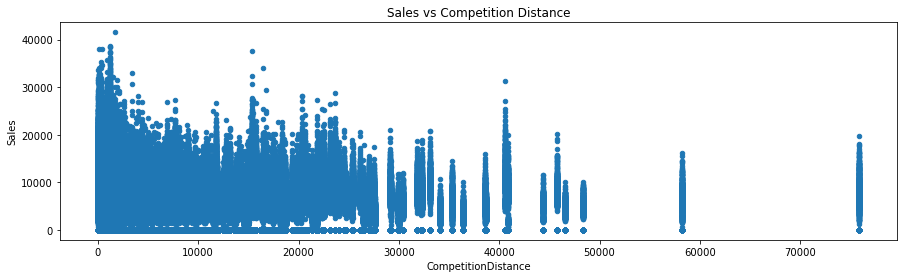

In [42]:
combined_data.plot(kind = "scatter", x = "CompetitionDistance", y = "Sales", figsize = (15, 4), 
                  title = "Sales vs Competition Distance")

#### Findings: CompetitionDistance is the distance in meteres to the nearest competitor store. 
#### The more nearer the two stores are, the more sales can be seen

# Finding Outliers

## Checking Distribution of Sales

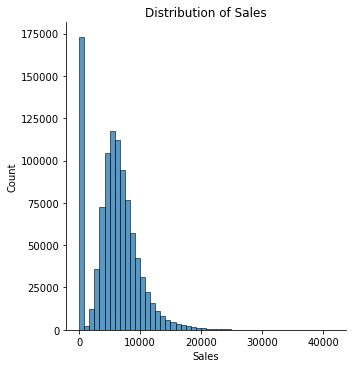

In [43]:
sns.displot(data = combined_data, x = "Sales", bins = 50).set(title = "Distribution of Sales")

Distribution of Sales Greater than 30k are very less so they might be outliers

# Getting Z-Score

If the Z-Score of a datapoint is greater than 3 that can be considered as an Outlier

Mean of Sales:  5773.818972305593
Standard Deviation of Sales:  3849.9242828437527
Total outlier in Data Set Are:  9731
Maximum Sales Outlier:  41551
Minimum Sales Outlier:  17325
Percentage of Outliers from overall data:  0.96 %


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Outlier Distribution of Sales')]

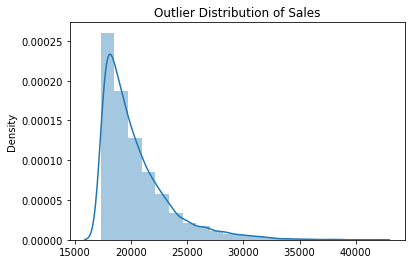

In [44]:
mean_of_sales = np.mean(combined_data['Sales'])
std_of_sales = np.std(combined_data['Sales'])
print("Mean of Sales: ", mean_of_sales)
print("Standard Deviation of Sales: ", std_of_sales)

threshold = 3
outlier = []
for i in combined_data['Sales']:
    z = (i - mean_of_sales)/std_of_sales
    if z > threshold:
        outlier.append(i)

print("Total outlier in Data Set Are: ", len(outlier))
print("Maximum Sales Outlier: ", max(outlier))
print("Minimum Sales Outlier: ", min(outlier))
print("Percentage of Outliers from overall data: ", np.round(len(outlier)*100/len(combined_data),2), "%")
sns.distplot(x = outlier, bins = 20).set(title = "Outlier Distribution of Sales")


In [45]:
#Looking for Outliers
sales_zero = combined_data.loc[combined_data['Sales'] == 0]
sales_greater_than_30 = combined_data.loc[combined_data['Sales'] > 30000]

print("Length of Actual Data Set: ", len(combined_data))
print("Length of data where sales is 0:", len(sales_zero),
     " which is ", np.round(len(sales_zero)/len(combined_data)*100,2), "% of the whole data")

print("Length of data which is greater than 30: ", len(sales_greater_than_30),
     " which is ", len(sales_greater_than_30)/len(combined_data)*100)

Length of Actual Data Set:  1017209
Length of data where sales is 0: 172871  which is  16.99 % of the whole data
Length of data which is greater than 30:  153  which is  0.015041156733768577


Dropping sales which are greater than 30k as they are very less in the dataset and are probably outliers.

In [46]:
combined_data.drop(combined_data.loc[combined_data['Sales'] > 30000].index, inplace = True)
combined_data.shape

(1017056, 18)

# Further EDA - Exploring Exceptional Cases

Looking for a scenario where the Stores are open and yet there is no sales on that day

In [47]:
#no sales when Stores when Open
no_holiday_zero_sales = combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) &
                                         (combined_data['StateHoliday'] == 0) & (combined_data['SchoolHoliday'] == 0)]

print("Size of the data where sales were zero even when stores were open: ", len(no_holiday_zero_sales))
no_holiday_zero_sales.head()

Size of the data where sales were zero even when stores were open:  12


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
22589,25,4,2014-02-13,0,0,1,0,0,0,c,a,430.0,4.0,2003.0,0,0.0,0.0,0
22590,25,3,2014-02-12,0,0,1,0,0,0,c,a,430.0,4.0,2003.0,0,0.0,0.0,0
25212,28,4,2014-09-04,0,0,1,1,0,0,a,a,1200.0,10.0,2014.0,1,6.0,2015.0,"Mar,Jun,Sept,Dec"
205303,227,4,2014-09-11,0,0,1,0,0,0,a,a,2370.0,9.0,2013.0,0,0.0,0.0,0
297110,327,3,2014-03-12,0,0,1,0,0,0,c,c,1390.0,12.0,2004.0,0,0.0,0.0,0


Removing these data points too as they are an exceptional case

In [48]:
combined_data.drop(combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & (combined_data['StateHoliday'] == 0) & (combined_data['SchoolHoliday'] == 0)].index, inplace = True)
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [49]:
combined_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


# Converting Categorical Variable to Numeric

In [50]:
# Extracting Year and Month from Date
combined_data['Year'] = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))
combined_data.drop(['Date'], axis = 1, inplace = True)

In [51]:
combined_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [52]:
# encoding all categorical variable to numeric values
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

combined_data['StoreType'] = label_encoder.fit_transform(combined_data['StoreType'])
combined_data['Assortment'] = label_encoder.fit_transform(combined_data['Assortment'])

#promo interval
combined_data['PromoInterval'].loc[combined_data['PromoInterval'] == "Jan,Apr,Jul,Oct"] = 1
combined_data['PromoInterval'].loc[combined_data['PromoInterval'] == "Feb,May,Aug,Nov"] = 2
combined_data['PromoInterval'].loc[combined_data['PromoInterval'] == "Mar,Jun,Sept,Dec"] = 3


#State Holiday
combined_data['StateHoliday'].loc[combined_data['StateHoliday'] == 'a'] = 1
combined_data['StateHoliday'].loc[combined_data['StateHoliday'] == 'b'] = 2
combined_data['StateHoliday'].loc[combined_data['StateHoliday'] == 'c'] = 3

combined_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [53]:
combined_data['StateHoliday'] = pd.to_numeric(combined_data['StateHoliday'])
combined_data['PromoInterval'] = pd.to_numeric(combined_data['PromoInterval'])


<AxesSubplot:>

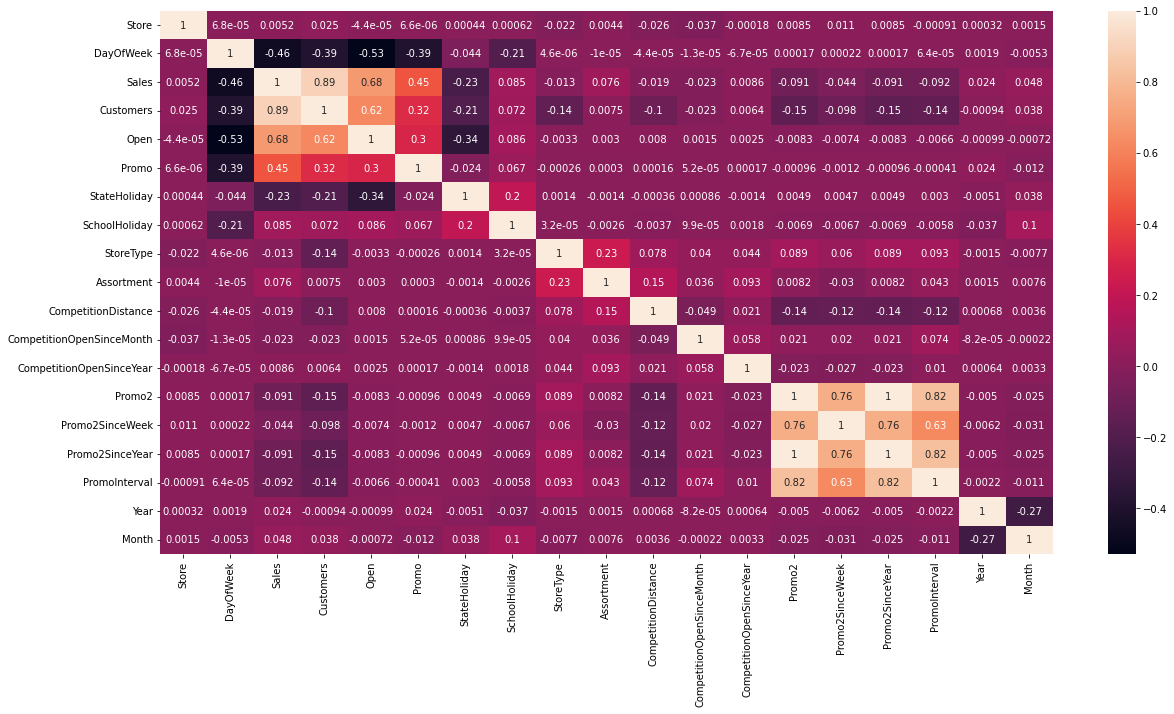

In [54]:
plt.figure(figsize=(20,10))
sns.heatmap(combined_data.corr(), annot = True)

#### Correlation map Shows
- Sales is highly correlated with Customers, Open, Promo code
- Promo code is highly correlated to Promo2SinceWeek, Promo2SinceYear, PromoInterval

<AxesSubplot:>

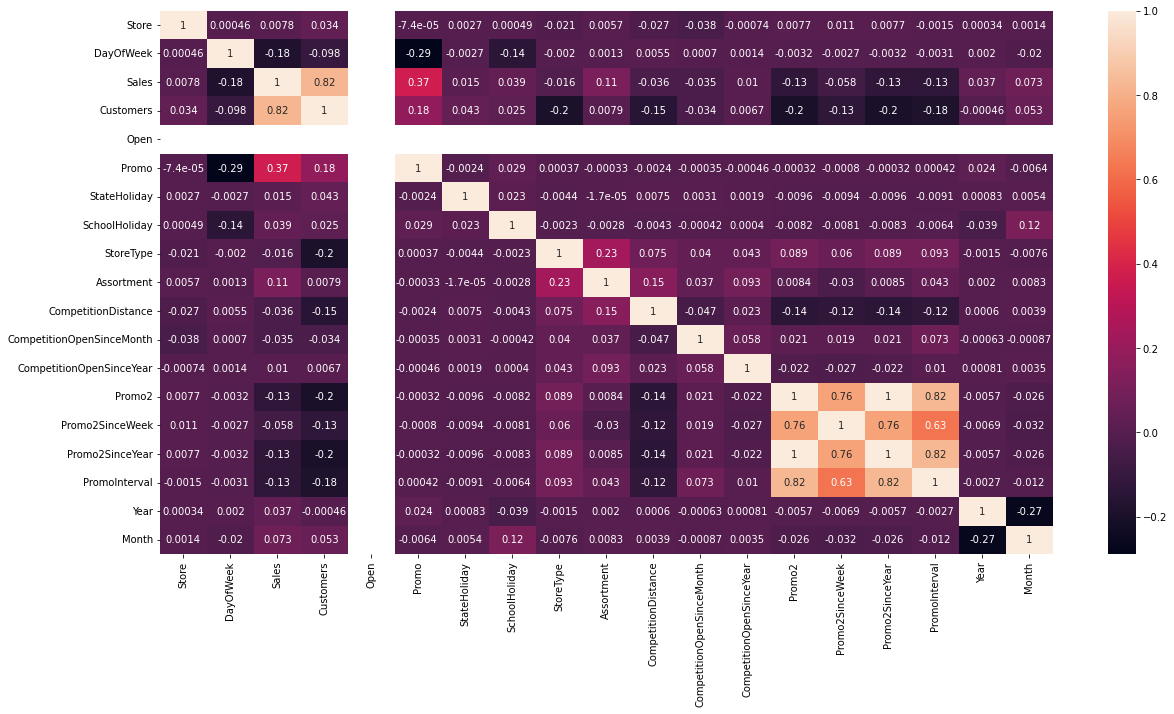

In [55]:
plt.figure(figsize=(20,10))
sns.heatmap(combined_data[combined_data['Open'] == 1].corr(), annot = True)

## Implementing Models

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

In [57]:
#Subsetting the Data
combined_data_subset_open = combined_data[combined_data['Open'] == 1]
combined_data_subset_closed = combined_data[combined_data['Open'] == 0]
x_train, x_test, y_train, y_test_open = train_test_split(combined_data_subset_open.drop(['Sales', 'Customers', 'Open'], axis = 1),
                                                        combined_data_subset_open['Sales'], test_size = 0.20)

In [58]:
#setting the error value
epsilon = 1e-10

In [59]:
#checking the x_train columns
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month'],
      dtype='object')

# Linear Regression

In [60]:
from sklearn import linear_model

#making regression model
reg_model = linear_model.LinearRegression() 
reg_model.fit(x_train, y_train)

prediction_open = reg_model.predict(x_test)

prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))


print("r2_score: ", r2_score(y_test, prediction))
print("Mean Absolute Error: %.2f" % mean_absolute_error(y_test, prediction))
print("Root Mean Squared Error: ", math.sqrt(mean_squared_error(y_test, prediction)))

r2_score:  0.7738494314877694
Mean Absolute Error: 998.08
Root Mean Squared Error:  1943.9464500862318


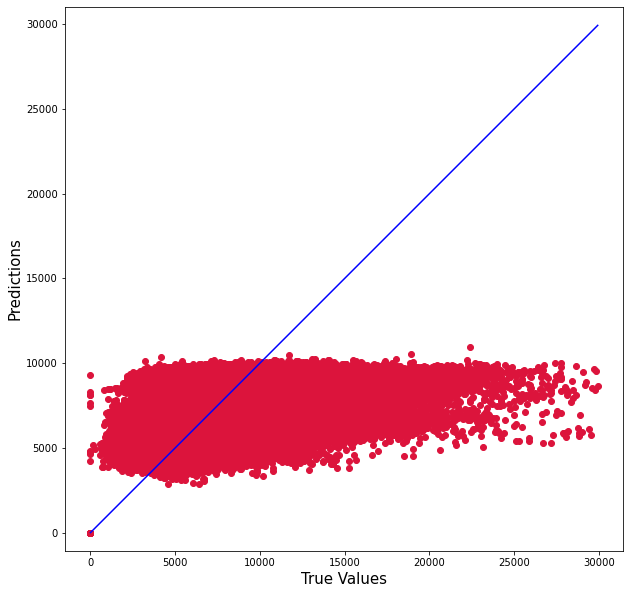

In [62]:
plt.figure(figsize = (10, 10))
plt.scatter(y_test, prediction, c = "crimson")

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

# SGD Regressor


Stochastic Gradient Descent (SGD) is a simple yet efficient optimization algorithm used to find the values of parameters/coefficients of functions that minimize a cost function.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


r2_score:  -8.257048994715039e+24
Mean Absolute Error: 4722570076733833.00
Root Mean Squared Error:  1.174621338528667e+16


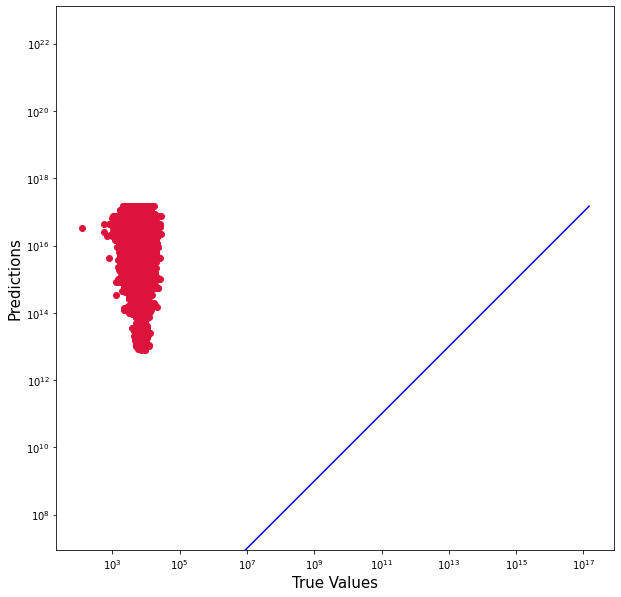

In [63]:
from sklearn.linear_model import SGDRegressor
#increasing the max_iter value leads to overfitting
sgd_regressor_model = SGDRegressor(max_iter = 2)
sgd_regressor_model.fit(x_train, y_train)

prediction_open = sgd_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ", r2_score(y_test, prediction))
print("Mean Absolute Error: %.2f" % mean_absolute_error(y_test, prediction))
print("Root Mean Squared Error: ", math.sqrt(mean_squared_error(y_test, prediction)))

plt.figure(figsize = (10, 10))
plt.scatter(y_test, prediction, c = 'crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

# Random Forest Regressor

r2_score:  0.9651378861785246
Mean absolute error: 356.92
Root Mean Squared Error:  763.2420925639933


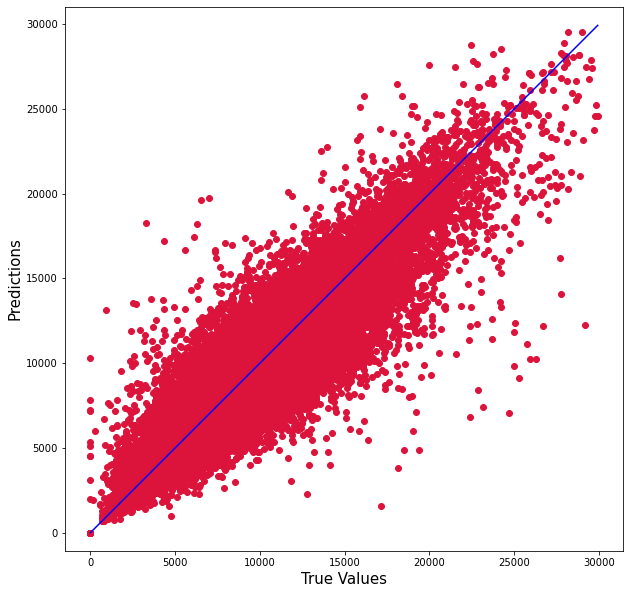

In [64]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(x_train, y_train)

prediction_open = random_forest_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ", r2_score(y_test, prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, prediction))
print("Root Mean Squared Error: ", math.sqrt(mean_squared_error(y_test, prediction)))

plt.figure(figsize = (10, 10))
plt.scatter(y_test, prediction, c = 'crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

# Decision Tree Regressor

r2_score:  0.951604745907014
Mean absolute error: 420.79
Root Mean Squared Error:  899.2632437202129


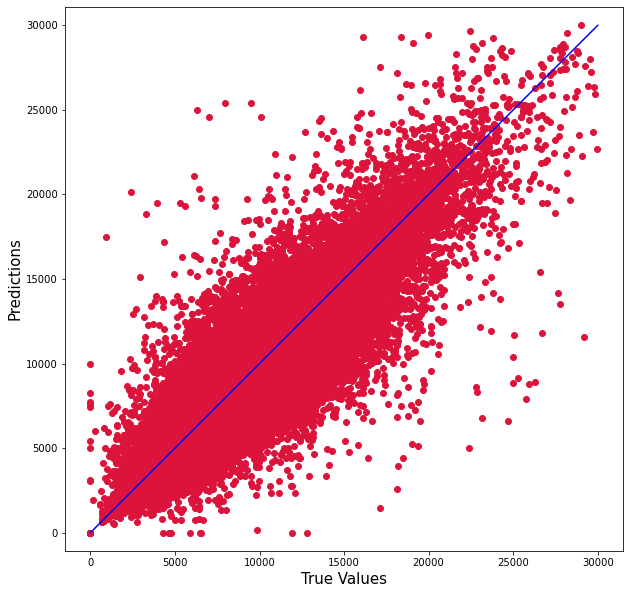

In [67]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor_model = DecisionTreeRegressor()
decision_tree_regressor_model.fit(x_train, y_train)

prediction_open = decision_tree_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ", r2_score(y_test, prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, prediction))
print("Root Mean Squared Error: ", math.sqrt(mean_squared_error(y_test, prediction)))

plt.figure(figsize = (10, 10))
plt.scatter(y_test, prediction, c = 'crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

Random Forest Regressor had the lowest error as compared to other stores that means it is better at predicting sales than other models so we have selected that as our model

# Understanding the important features

In [68]:
#Getting weights of all the features used in the data
feature_importance = random_forest_regressor_model.feature_importances_
feature_importance

array([0.17819183, 0.08203544, 0.14031614, 0.00116797, 0.01263477,
       0.03429042, 0.03022022, 0.20755058, 0.07143988, 0.07721113,
       0.00320632, 0.02834823, 0.03325032, 0.01355281, 0.023832  ,
       0.06275195])

In [69]:
#features used
columns = list(x_train.columns)
columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'Year',
 'Month']

In [70]:
#getting the importance value of each feature
feature_importance_value = []
for i in range(len(feature_importance)):
    feature_importance_value.append(round(feature_importance[i],5))
feature_importance_value

[0.17819,
 0.08204,
 0.14032,
 0.00117,
 0.01263,
 0.03429,
 0.03022,
 0.20755,
 0.07144,
 0.07721,
 0.00321,
 0.02835,
 0.03325,
 0.01355,
 0.02383,
 0.06275]

In [71]:
#making a dataframe
feature_importance_df = pd.DataFrame({"Features": columns, 
                                     "Values": feature_importance_value})
feature_importance_df

,Features,Values
0,Store,0.17819
1,DayOfWeek,0.08204
2,Promo,0.14032
3,StateHoliday,0.00117
4,SchoolHoliday,0.01263
5,StoreType,0.03429
6,Assortment,0.03022
7,CompetitionDistance,0.20755
8,CompetitionOpenSinceMonth,0.07144
9,CompetitionOpenSinceYear,0.07721


In [74]:
feature_importance_df.sort_values(by = ["Values"], inplace = True, ascending = False)
feature_importance_df


,Features,Values
7,CompetitionDistance,0.20755
0,Store,0.17819
2,Promo,0.14032
1,DayOfWeek,0.08204
9,CompetitionOpenSinceYear,0.07721
8,CompetitionOpenSinceMonth,0.07144
15,Month,0.06275
5,StoreType,0.03429
12,Promo2SinceYear,0.03325
6,Assortment,0.03022


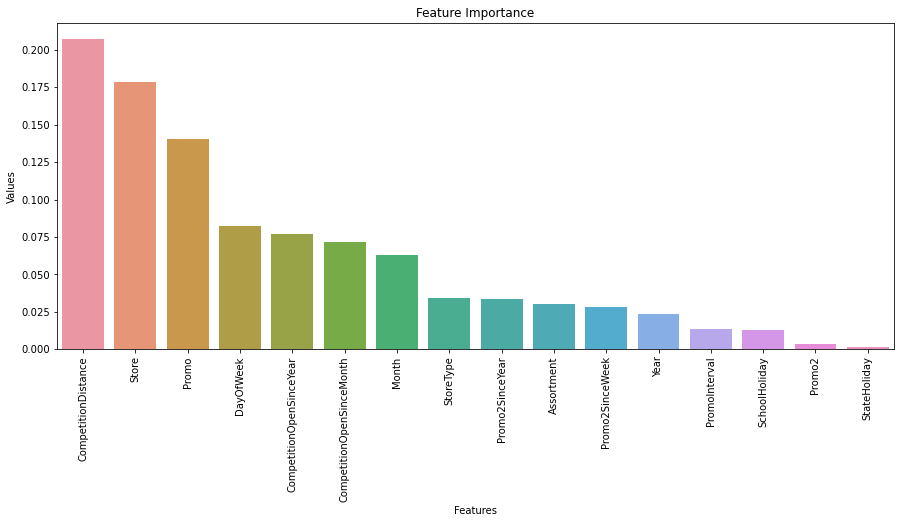

In [73]:
# Feature Importance
plt.figure(figsize = (15, 6))
sns.barplot(x = feature_importance_df["Features"], y = feature_importance_df['Values'],
           data = feature_importance_df).set(title = "Feature Importance")

plt.xticks(rotation = 90)
plt.show()

# Conclusion

- Feature Engineering is a very important, e.g. removal of the 'Open' feature
- Closer competition distance make stores more competitive and thus using Promo Codes can help them to boost sales
- Store Type affects the sales
- Promo code can help increase in the competition and lead to more sales
- Since most of the stores are closed on Holidays, the feature has no effect on sales